In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from torchinfo import summary
from skimage import io
import os
import pandas as pd
from skimage import transform as tr
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import tqdm
from datetime import datetime
import pytz
from torchmetrics.classification import BinaryJaccardIndex

2024-04-03 08:12:00.067815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 08:12:00.067916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 08:12:00.194387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Defining paths for loading data
root = "/kaggle/input/embryodata/"
test_data_path = root + "Images/Images/test/Images/"
ground_truth_test = root + "GroundTruth/GroundTruth/test/GroundTruth_QCANet/"

test_data_paths = np.array([test_data_path+i for i in os.listdir(test_data_path)])

In [3]:
#Custom Torch dataset class to create a dataset and pass it to Torch dataloaders
class EmbryoImageDataset(Dataset):
    def __init__(self, 
                 image_paths, 
                 ground_truth_dir, 
                 transform=None, 
                 flip_augmentation = [False, None],
                test_data = False):
        self.ground_truth_dir = ground_truth_dir
        self.image_paths = image_paths
        self.transform = transform
        self.flip_augmentation = flip_augmentation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image = io.imread(self.image_paths[index])
        filename = self.image_paths[index].split('/')[-1]
        ground_truth = io.imread(self.ground_truth_dir + filename)
        
        if self.transform is not None:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)
            
        if self.flip_augmentation[0]:
            #print("FLIPPING", self.flip_augmentation[0], self.flip_augmentation[1] )
            image = np.flip(image, axis = self.flip_augmentation[1])
            ground_truth = np.flip(ground_truth, axis = self.flip_augmentation[1])
            
        if test_data: 
            #Ground truth of test data was instance segmentation ground truth, therefore all values bigger than 0 should be set to 1
            ground_truth = ((ground_truth>0)*1).astype(ground_truth.dtype) 
    
        return torch.from_numpy(image.copy().astype('float32')), torch.from_numpy(ground_truth.copy().astype('float32'))
    

class NormalizeImage(object):
    
    def __init__(self):
        pass
    
    def __call__(self, image):
        
        img = (image-np.min(image))/(np.max(image)-np.min(image))
        
        return img
    
#Class that can perform a transform that interpolates the images along z, according to the resolution. 
# This class also makes sure that the object is of the desired size. In this case 128x128x128
class Resize_and_pad(object):
    
    def __init__(self, resolution = [0.8,0.8,1.75], desired_size = 128):
        
        self.resolution = resolution
        self.desired_size = desired_size
        
    def __call__(self, image):
        
        
        shape = np.shape(image)
        resize_factor = np.array(self.resolution)/0.8

        resized_image = tr.resize(image, 
                                  (shape[0]*resize_factor[2], 
                                   shape[1]*resize_factor[1], 
                                   shape[2]*resize_factor[0]),
                                     order=1)
        
        delta_shape = [128-value for value in resized_image.shape]
        max_pad_width = np.max(delta_shape)

        padded_image = np.pad(resized_image,[[0,max_pad_width],[0,max_pad_width],[0,max_pad_width]], mode = 'reflect')
        final_image = padded_image[:self.desired_size,:self.desired_size,:self.desired_size]
        
        return final_image

In [4]:
#Here the train and test dataset are created

#For the test set there was a different resolution so different transformation is needed
composed_test = composed = transforms.Compose([NormalizeImage(), Resize_and_pad(resolution= [0.8,0.8,2.0])])

#Creating the test dataset for when the model is fully trained
test_data = EmbryoImageDataset(image_paths = test_data_paths,
                              ground_truth_dir= ground_truth_test,
                              test_data= True, transform = composed_test)

print(len(test_data))

44


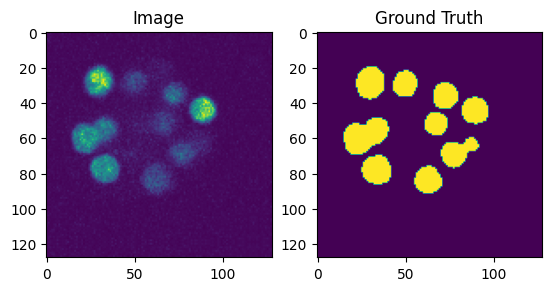

torch.Size([128, 128, 128]) torch.Size([128, 128, 128])
torch.float32 torch.float32


In [5]:
#Visualizing a random training sample from the test dataset

N = 64
fig, ax = plt.subplots(1, 2)

index = int(np.random.rand()*len(test_data))

image, truth = test_data[index]

ax[0].imshow(image[N])
ax[0].set_title("Image")
ax[1].imshow(truth[N])
ax[1].set_title("Ground Truth")
plt.show()

print(image.shape, truth.shape)
print(image.dtype, truth.dtype)

In [14]:
#Softmax version of our own very straightforward, albeit not super nice, implementation of the U-net 3D architecture by the paper: '3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation'
class UNet3D_softmax(nn.Module):
    
    def __init__(self, in_channels = 1, out_channels = 2):
        super(UNet3D_softmax, self).__init__()
        
        #Activation functions and maxpooling
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
        self.maxpool = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #Encoder Block 1
        self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 32, kernel_size = (3,3,3), padding = 1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn2 = nn.BatchNorm3d(64)
        
        #Encoder Block 2
        self.conv3 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn3 = nn.BatchNorm3d(64)
        self.conv4 = nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn4 = nn.BatchNorm3d(128)
        
        #Encoder Block 3
        self.conv5 = nn.Conv3d(in_channels = 128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn5 = nn.BatchNorm3d(128)
        self.conv6 = nn.Conv3d(in_channels = 128, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn6 = nn.BatchNorm3d(256)
        
        #Bottleneck block
        self.conv7 = nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn7 = nn.BatchNorm3d(256)
        self.conv8 = nn.Conv3d(in_channels = 256, out_channels = 512, kernel_size = (3,3,3), padding = 1)
        self.bn8 = nn.BatchNorm3d(512)
        
        #Decoder Block 1
        self.upconv1 = nn.ConvTranspose3d(in_channels = 512, out_channels = 512, kernel_size = (2,2,2), stride = 2)
        self.conv9 = nn.Conv3d(in_channels = 512+256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn9 = nn.BatchNorm3d(256)
        self.conv10 = nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn10 = nn.BatchNorm3d(256)
        
        #Decoder Block 2
        self.upconv2 = nn.ConvTranspose3d(in_channels = 256, out_channels = 256, kernel_size = (2,2,2), stride = 2)
        self.conv11 = nn.Conv3d(in_channels = 256+128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn11 = nn.BatchNorm3d(128)
        self.conv12 = nn.Conv3d(in_channels = 128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn12 = nn.BatchNorm3d(128)
        
        #Decoder Block 3 
        self.upconv3 = nn.ConvTranspose3d(in_channels = 128, out_channels = 128, kernel_size = (2,2,2), stride = 2)
        self.conv13 = nn.Conv3d(in_channels = 128+64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn13 = nn.BatchNorm3d(64)
        self.conv14 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn14 = nn.BatchNorm3d(64)
        
        #Final convolution
        self.conv15 = nn.Conv3d(in_channels = 64, out_channels = out_channels, kernel_size = (1,1,1))
        
    def forward(self, input):

        #Encoder Block 1
        out = self.relu(self.bn1(self.conv1(input)))
        out = self.relu(self.bn2(self.conv2(out)))
        skip_connection1 = out
        out = self.maxpool(out)

        #Encoder Block 2
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out)))
        skip_connection2 = out
        out = self.maxpool(out)

        #Encoder Block 3
        out = self.relu(self.bn5(self.conv5(out)))
        out = self.relu(self.bn6(self.conv6(out)))
        skip_connection3 = out
        out = self.maxpool(out)

        #Bottleneck layer
        out = self.relu(self.bn7(self.conv7(out)))
        out = self.relu(self.bn8(self.conv8(out)))

        #Decoder Block 1
        out = self.upconv1(out)
        out = torch.cat(tensors = (out, skip_connection3), dim = 1)
        out = self.relu(self.bn9(self.conv9(out)))
        out = self.relu(self.bn10(self.conv10(out)))

        #Decoder Block 2
        out = self.upconv2(out)
        out = torch.cat(tensors = (out, skip_connection2), dim = 1)
        out = self.relu(self.bn11(self.conv11(out)))
        out = self.relu(self.bn12(self.conv12(out)))

        #Decoder Block 3
        out = self.upconv3(out)
        out = torch.cat(tensors = (out, skip_connection1), dim = 1)
        out = self.relu(self.bn13(self.conv13(out)))
        out = self.relu(self.bn14(self.conv14(out)))

        #Final convolution + sigmoid activation
        out = self.conv15(out)
        out = self.softmax(out)

        return out

In [15]:
#Our own very straightforward, albeit not super nice, implementation of the U-net 3D architecture by the paper: '3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation'
class UNet3D(nn.Module):
    
    def __init__(self, in_channels = 1, out_channels = 1):
        super(UNet3D, self).__init__()
        
        #Activation functions and maxpooling
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.maxpool = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #Encoder Block 1
        self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 32, kernel_size = (3,3,3), padding = 1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn2 = nn.BatchNorm3d(64)
        
        #Encoder Block 2
        self.conv3 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn3 = nn.BatchNorm3d(64)
        self.conv4 = nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn4 = nn.BatchNorm3d(128)
        
        #Encoder Block 3
        self.conv5 = nn.Conv3d(in_channels = 128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn5 = nn.BatchNorm3d(128)
        self.conv6 = nn.Conv3d(in_channels = 128, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn6 = nn.BatchNorm3d(256)
        
        #Bottleneck block
        self.conv7 = nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn7 = nn.BatchNorm3d(256)
        self.conv8 = nn.Conv3d(in_channels = 256, out_channels = 512, kernel_size = (3,3,3), padding = 1)
        self.bn8 = nn.BatchNorm3d(512)
        
        #Decoder Block 1
        self.upconv1 = nn.ConvTranspose3d(in_channels = 512, out_channels = 512, kernel_size = (2,2,2), stride = 2)
        self.conv9 = nn.Conv3d(in_channels = 512+256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn9 = nn.BatchNorm3d(256)
        self.conv10 = nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn10 = nn.BatchNorm3d(256)
        
        #Decoder Block 2
        self.upconv2 = nn.ConvTranspose3d(in_channels = 256, out_channels = 256, kernel_size = (2,2,2), stride = 2)
        self.conv11 = nn.Conv3d(in_channels = 256+128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn11 = nn.BatchNorm3d(128)
        self.conv12 = nn.Conv3d(in_channels = 128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn12 = nn.BatchNorm3d(128)
        
        #Decoder Block 3 
        self.upconv3 = nn.ConvTranspose3d(in_channels = 128, out_channels = 128, kernel_size = (2,2,2), stride = 2)
        self.conv13 = nn.Conv3d(in_channels = 128+64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn13 = nn.BatchNorm3d(64)
        self.conv14 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn14 = nn.BatchNorm3d(64)
        
        #Final convolution
        self.conv15 = nn.Conv3d(in_channels = 64, out_channels = out_channels, kernel_size = (1,1,1))
        
    def forward(self, input):

        #Encoder Block 1
        out = self.relu(self.bn1(self.conv1(input)))
        out = self.relu(self.bn2(self.conv2(out)))
        skip_connection1 = out
        out = self.maxpool(out)

        #Encoder Block 2
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out)))
        skip_connection2 = out
        out = self.maxpool(out)

        #Encoder Block 3
        out = self.relu(self.bn5(self.conv5(out)))
        out = self.relu(self.bn6(self.conv6(out)))
        skip_connection3 = out
        out = self.maxpool(out)

        #Bottleneck layer
        out = self.relu(self.bn7(self.conv7(out)))
        out = self.relu(self.bn8(self.conv8(out)))

        #Decoder Block 1
        out = self.upconv1(out)
        out = torch.cat(tensors = (out, skip_connection3), dim = 1)
        out = self.relu(self.bn9(self.conv9(out)))
        out = self.relu(self.bn10(self.conv10(out)))

        #Decoder Block 2
        out = self.upconv2(out)
        out = torch.cat(tensors = (out, skip_connection2), dim = 1)
        out = self.relu(self.bn11(self.conv11(out)))
        out = self.relu(self.bn12(self.conv12(out)))

        #Decoder Block 3
        out = self.upconv3(out)
        out = torch.cat(tensors = (out, skip_connection1), dim = 1)
        out = self.relu(self.bn13(self.conv13(out)))
        out = self.relu(self.bn14(self.conv14(out)))

        #Final convolution + sigmoid activation
        out = self.conv15(out)
        out = self.sig(out)

        return out
    
#Prediction accuracy measure
def IoU(prediction, ground_truth):
    
    #We first apply a threshold to the prediction, to ensure a binary mask is made that can be 
    #compared to the ground truth. Ground truth should already be a binary mask
    
    threshold = 0.99
    
    prediction = (prediction.squeeze()>threshold)*1
    ground_truth = ground_truth.squeeze()
    

    pred_diff = prediction.flatten()-ground_truth.flatten()
    
    TP = torch.sum((pred_diff == 0)*ground_truth.flatten()) #Amount of true positives
    FP_or_FN = torch.sum(pred_diff!= 0) #Amount of false positives and false negatives
    
    value = TP/(TP+FP_or_FN)
    
    return value

def test_IoU(test_data, network, device):
    """
    Function that returns the average IoU based on prediction of an input network on a test data set as input
    """
    #Amount of image-ground truth pairs
    dataset_length = len(test_data)
    average_IoU = 0
    new_IoU = 0
    
    
    with torch.no_grad():
        
        for image,truth in tqdm.tqdm(test_data):

            if device == 'cpu':
                pass
            else:
                image = image.to(device)
                truth = truth.to(device)

            prediction = network(image.unsqueeze(0).unsqueeze(0))
            new_IoU = IoU(prediction.squeeze(), truth)
            average_IoU += new_IoU
            
    if device == 'cpu':
        pass
    else:
        average_IoU = average_IoU.cpu() #If device is cuda, then move tensor to cpu host memory
            
    return (average_IoU/dataset_length).numpy()

def plot_prediction_example(test_data, network, device, print_IoU = False):
    
    IoU_score = 0
    length = len(test_data)
    
    random_index = np.random.randint(0,length)
    
    image, truth = test_data[random_index]
    prediction = torch.zeros(image.size())
    
    if device == 'cpu':
        pass
    else:
        image = image.to(device)
        truth = truth.to(device)
    
    with torch.no_grad():
        prediction = network(image.unsqueeze(0).unsqueeze(0))
    
    prediction = prediction.squeeze()
        
    fig, ax = plt.subplots(1,3)
    
    slice_number = image.shape[0]//2
    
    print(f'Plotting prediction of test data example number {random_index+1}')
    
    if print_IoU:
        IoU_score = IoU(prediction, truth)
        image = image.to(device)
        truth = truth.to(device)
        metric = BinaryJaccardIndex(threshold = 0.5)
        if device == 'cpu':
            pass
        else:
            metric = metric.to(device)
        torch_IoU_score = metric(prediction, truth)
        
        print(f'IoU score of this example: {IoU_score}(Torch IoU: {torch_IoU_score})')
    
    threshold = 0.99
    prediction = (prediction>threshold)*1
    
    if device == 'cpu':
        pass
    else:
        image = image.cpu()
        truth = truth.cpu()
        prediction = prediction.cpu()
    
    ax[0].imshow(image[slice_number])
    ax[0].set_title("Input image")
    
    ax[1].imshow(prediction[slice_number])
    ax[1].set_title("Network Prediction")
    
    ax[2].imshow(truth[slice_number])
    ax[2].set_title("Ground truth")

In [16]:
#Specifying the device, testing whether there is a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Creating an instance of the network and moving it to the created device
Unet_bce_softmax = UNet3D_softmax(in_channels= 1, out_channels = 2).to(device)
Unet_bce = UNet3D(in_channels= 1, out_channels = 1).to(device)
Unet_DICE = UNet3D(in_channels= 1, out_channels = 1).to(device)

cuda


In [17]:
#Loading the previously trained networks, be sure to upload the saved files as datasets on Kaggle

bce_softmax_file = torch.load('/kaggle/input/sofmax-unet/Softmax U-net training 15 BCE loss/checkpoint_file.tar', torch.device(device))
bce_sigmoid_file = torch.load('/kaggle/input/checkpoints-u-net-bceloss/checkpoint_file.tar', torch.device(device))
DICE_sigmoid_file = torch.load('/kaggle/input/checkpoints-unet/checkpoint_file.tar', torch.device(device))

In [21]:
#Loading the state (and therefore parameters) of the trained networks

#Softmax UNet3D with BCE loss
Unet_bce_softmax.load_state_dict(bce_softmax_file['net_state_dict'])


train_loss_bce_softmax = [i.cpu().numpy() for i in bce_softmax_file['loss_acc']['Train loss']]
train_accuracy_bce_softmax = [i.cpu().numpy() for i in bce_softmax_file['loss_acc']['Train accuracy']]
val_loss_bce_softmax = [i.cpu().numpy() for i in bce_softmax_file['loss_acc']['Validation loss']] 
val_accuracy_bce_softmax = [i.cpu().numpy() for i in bce_softmax_file['loss_acc']['Validation accuracy']]  
epochs_bce_softmax = bce_softmax_file['epoch']

#Sigmoid UNet3D BCE loss
Unet_bce.load_state_dict(bce_sigmoid_file['net_state_dict'])

train_loss_bce = [i.cpu().numpy() for i in bce_sigmoid_file['loss_acc']['Train loss']]
train_accuracy_bce = [i.cpu().numpy() for i in bce_sigmoid_file['loss_acc']['Train accuracy']]
val_loss_bce = [i.cpu().numpy() for i in bce_sigmoid_file['loss_acc']['Validation loss']] 
val_accuracy_bce = [i.cpu().numpy() for i in bce_sigmoid_file['loss_acc']['Validation accuracy']]  
epochs_bce = bce_sigmoid_file['epoch']

#Sigmoid UNet3D DICE loss
Unet_DICE.load_state_dict(DICE_sigmoid_file['net_state_dict'])

train_loss_DICE = [i.cpu().numpy() for i in DICE_sigmoid_file['loss_acc']['Train loss']]
train_accuracy_DICE = [i.cpu().numpy() for i in DICE_sigmoid_file['loss_acc']['Train accuracy']]
val_loss_DICE = [i.cpu().numpy() for i in DICE_sigmoid_file['loss_acc']['Validation loss']] 
val_accuracy_DICE = [i.cpu().numpy() for i in DICE_sigmoid_file['loss_acc']['Validation accuracy']]  
epochs_DICE = DICE_sigmoid_file['epoch']

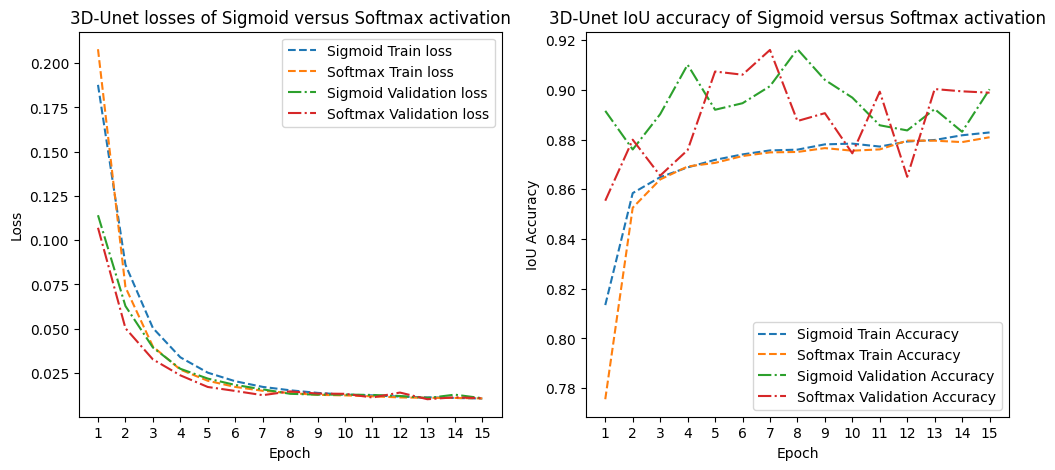

In [49]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot([i for i in range(1,epochs_bce+2)],train_loss_bce, label = 'Sigmoid Train loss', ls = '--')
ax[0].plot([i for i in range(1,epochs_bce_softmax+2)],train_loss_bce_softmax, label = 'Softmax Train loss', ls = '--')
ax[0].plot([i for i in range(1,epochs_bce+2)],val_loss_bce, label = 'Sigmoid Validation loss', ls = '-.')
ax[0].plot([i for i in range(1,epochs_bce_softmax+2)],val_loss_bce_softmax, label = 'Softmax Validation loss', ls = '-.')
ax[0].legend()
ax[0].set_xticks(np.linspace(1,15,15))
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title('3D-Unet losses of Sigmoid versus Softmax activation')

ax[1].plot([i for i in range(1,epochs_bce+2)],train_accuracy_bce, label = 'Sigmoid Train Accuracy', ls = '--')
ax[1].plot([i for i in range(1,epochs_bce_softmax+2)],train_accuracy_bce_softmax, label = 'Softmax Train Accuracy', ls = '--')
ax[1].plot([i for i in range(1,epochs_bce+2)],val_accuracy_bce, label = 'Sigmoid Validation Accuracy', ls = '-.')
ax[1].plot([i for i in range(1,epochs_bce_softmax+2)],val_accuracy_bce_softmax, label = 'Softmax Validation Accuracy', ls = '-.')
ax[1].legend()
ax[1].set_xticks(np.linspace(1,15,15))
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("IoU Accuracy")
ax[1].set_title('3D-Unet IoU accuracy of Sigmoid versus Softmax activation')

plt.show()

fig.savefig('/kaggle/working/Softmax_Vs_Sigmoid.png')


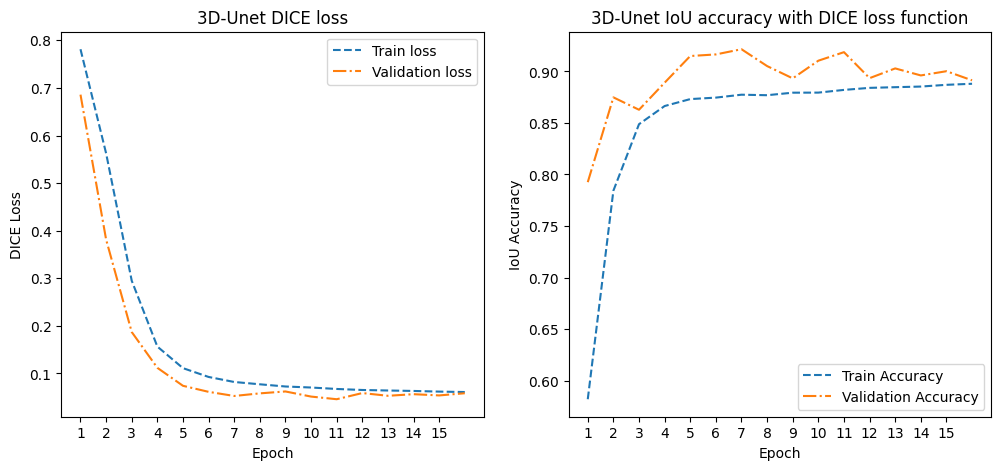

In [52]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot([i for i in range(1,epochs_DICE+2)],train_loss_DICE, label = 'Train loss', ls = '--')
ax[0].plot([i for i in range(1,epochs_DICE+2)],val_loss_DICE, label = 'Validation loss', ls = '-.')
ax[0].legend()
ax[0].set_xticks(np.linspace(1,15,15))
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("DICE Loss")
ax[0].set_title('3D-Unet DICE loss')

ax[1].plot([i for i in range(1,epochs_DICE+2)],train_accuracy_DICE, label = 'Train Accuracy', ls = '--')
ax[1].plot([i for i in range(1,epochs_DICE+2)],val_accuracy_DICE, label = 'Validation Accuracy', ls = '-.')
ax[1].legend()
ax[1].set_xticks(np.linspace(1,15,15))
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("IoU Accuracy")
ax[1].set_title('3D-Unet IoU accuracy with DICE loss function')

plt.show()

fig.savefig('/kaggle/working/DICE_scores.png')

In [54]:
IoU_score = test_IoU(test_data, Unet_DICE, device)

100%|██████████| 44/44 [00:25<00:00,  1.74it/s]


In [55]:
print(f'The IoU score of the test dataset: {IoU_score}')

The IoU score of the test dataset: 0.8432166576385498


In [ ]:
plot_prediction_example(test_data, net, device, True)